In [1]:
import tifffile as tiff
import numpy as np
import pandas as pd

In [2]:
from skimage.exposure import rescale_intensity

def create_rgb_image(input_data, channel_colors):
    """Takes a stack of 1- or 2-channel data and converts it to an RGB image

    Args:
        input_data: 4D stack of images to be converted to RGB
        channel_colors: list specifying the color for each channel

    Returns:
        numpy.array: transformed version of input data into RGB version

    Raises:
        ValueError: if ``len(channel_colors)`` is not equal
            to number of channels
        ValueError: if invalid ``channel_colors`` provided
        ValueError: if input_data is not 4D, with 1 or 2 channels
    """

    if len(input_data.shape) != 4:
        raise ValueError('Input data must be 4D, '
                         f'but provided data has shape {input_data.shape}')

    if input_data.shape[3] > 2:
        raise ValueError('Input data must have 1 or 2 channels, '
                         f'but {input_data.shape[-1]} channels were provided')

    valid_channels = ['red', 'green', 'blue']
    channel_colors = [x.lower() for x in channel_colors]

    if not np.all(np.isin(channel_colors, valid_channels)):
        raise ValueError('Only red, green, or blue are valid channel colors')

    if len(channel_colors) != input_data.shape[-1]:
        raise ValueError('Must provide same number of channel_colors as channels in input_data')

    rgb_data = np.zeros(input_data.shape[:3] + (3,), dtype='float32')

    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            current_img = input_data[img, :, :, channel]
            non_zero_vals = current_img[np.nonzero(current_img)]

            # if there are non-zero pixels in current channel, we rescale
            if len(non_zero_vals) > 0:

                percentiles = np.percentile(non_zero_vals, [5, 95])
                rescaled_intensity = rescale_intensity(current_img,
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')

                # get rgb index of current channel
                color_idx = np.where(np.isin(valid_channels, channel_colors[channel]))
                rgb_data[img, :, :, color_idx] = rescaled_intensity

    # create a blank array for red channel
    return rgb_data

In [3]:
file_name = "/workspaces/codex-analysis/data/NW_Ovary_16/Scan1/NW_1_Scan1.qptiff"
image_ndarray = tiff.imread(file_name)
image_ndarray.shape

(35, 50400, 28800)

In [4]:
nuclei_channel = 0
cell_channel = 21
# reshape roi_image from (channels, height, width) to (1, height, width, channels)
# then take nuclei_channel and cell_channel
formatted_image = image_ndarray.transpose(1, 2, 0)
formatted_image =  formatted_image[:, :, [nuclei_channel, cell_channel]]
formatted_image = np.expand_dims(formatted_image, axis=0)
print(formatted_image.shape)


(1, 50400, 28800, 2)


In [5]:
rgb_images = create_rgb_image(formatted_image, channel_colors=['green', 'blue'])
print(rgb_images.shape)
print(rgb_images.squeeze(0).shape)

(1, 50400, 28800, 3)
(50400, 28800, 3)


In [6]:
from PIL import Image
file_name = "/workspaces/codex-analysis/data/NW_Ovary_16/Scan1/NW_1_Scan1_rgb.png"
# save the RGB image to PNG
Image.fromarray((rgb_images.squeeze(0) * 255).astype('uint8')).save(file_name)

In [2]:
# select a region of interest (5k x 7k pixels)
# Determine center coordinates
center_x, center_y = image_ndarray.shape[1] // 2, image_ndarray.shape[2] // 2
print(center_x, center_y)

x0, y0 = center_x - 2500, center_y
# Define the region of interest (ROI) dimensions
roi_width, roi_height = 5000, 7000
x_start, x_end = x0 - roi_width // 2, x0 + roi_width // 2
y_start, y_end = y0 - roi_height // 2, y0 + roi_height // 2

# Select the ROI for each channel (assuming the image has multiple channels)
roi_image = image_ndarray[:, y_start:y_end, x_start:x_end]
print(roi_image.shape)
# Save the ROI to a new file
output_file = "/workspaces/codex-analysis/data/NW_Ovary_16/Scan1/NW_1_Scan1_dev.tiff"
tiff.imwrite(output_file, roi_image)

25200 14400
(35, 7000, 5000)


In [4]:
nuclei_channel = 0
cell_channel = 21
# reshape roi_image from (channels, height, width) to (1, height, width, channels)
# then take nuclei_channel and cell_channel
formatted_image = roi_image.transpose(1, 2, 0)
formatted_image =  formatted_image[:, :, [nuclei_channel, cell_channel]]
formatted_image = np.expand_dims(formatted_image, axis=0)
print(formatted_image.shape)


(1, 7000, 5000, 2)


In [ ]:
rgb_images = create_rgb_image(formatted_image, channel_colors=['green', 'blue'])
print(rgb_images.shape)
print(rgb_images.squeeze(0).shape)

In [ ]:
from PIL import Image
file_name = "/workspaces/codex-analysis/data/NW_Ovary_16/Scan1/NW_1_Scan1_dev_rgb.png"
# save the RGB image to PNG
Image.fromarray((rgb_images.squeeze(0) * 255).astype('uint8')).save(file_name)

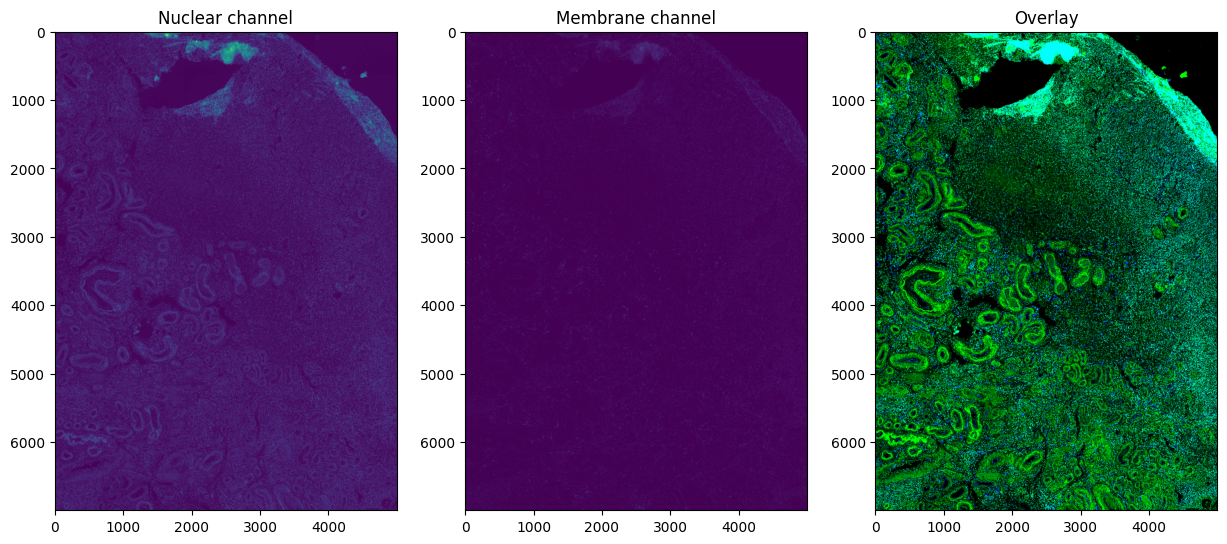

In [21]:
from matplotlib import pyplot as plt

idx = 0
# plot the data
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(formatted_image[idx, ..., 0])
ax[1].imshow(formatted_image[idx, ..., 1])
ax[2].imshow(rgb_images[idx, ...])

ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
ax[2].set_title('Overlay')

plt.show()